<a href="https://colab.research.google.com/github/Rohanrathod7/my-ml-labs/blob/main/08_Extreme_Gradient_Boosting_with_XGBoost/02_Regression_with_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


### 2 Regression with XGBoost

After a brief review of supervised regression, you'll apply XGBoost to the regression task of predicting house prices in Ames, Iowa. You'll learn about the two kinds of base learners that XGboost can use as its weak learners, and review how to evaluate the quality of your regression models.

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import datetime as dt
# Import confusion matrix and train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import Ridge, Lasso, LogisticRegression, LinearRegression
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier




url = "https://raw.githubusercontent.com/Rohanrathod7/my-ml-labs/main/08_Extreme_Gradient_Boosting_with_XGBoost/dataset/ames_housing_trimmed_processed.csv"
# Read the CSV file
# The original code tried to read a feather file as a CSV, and had a UnicodeDecodeError.
# The file extension is feather, so it should be read using pd.read_feather.
# Also, the variable name was confusing, it should be spotify_population.
ames_housing_trimmed_processed = pd.read_csv(url).apply(pd.to_numeric, errors='coerce')
display(ames_housing_trimmed_processed.head())

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,Remodeled,GrLivArea,BsmtFullBath,BsmtHalfBath,...,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,PavedDrive_P,PavedDrive_Y,SalePrice
0,60,65.0,8450,7,5,2003,0,1710,1,0,...,0,0,0,0,1,0,0,0,1,208500
1,20,80.0,9600,6,8,1976,0,1262,0,1,...,0,1,0,0,0,0,0,0,1,181500
2,60,68.0,11250,7,5,2001,1,1786,1,0,...,0,0,0,0,1,0,0,0,1,223500
3,70,60.0,9550,7,5,1915,1,1717,1,0,...,0,0,0,0,1,0,0,0,1,140000
4,60,84.0,14260,8,5,2000,0,2198,1,0,...,0,0,0,0,1,0,0,0,1,250000


**Which of these is a regression problem?**  
Here are 4 potential machine learning problems you might encounter in the wild. Pick the one that is a clear example of a regression problem.


- Recommending a restaurant to a user given their past history of restaurant visits and reviews for a dining aggregator app.

- Predicting which of several thousand diseases a given person is most likely to have given their symptoms.


- Tagging an email as spam/not spam based on its content and metadata (sender, time sent, etc.).


- --Predicting the expected payout of an auto insurance claim given claim properties (car, accident type, driver prior history, etc.).


### Objective (loss) functions and base learners

**Decision trees as base learners**  
It's now time to build an XGBoost model to predict house prices - not in Boston, Massachusetts, as you saw in the video, but in Ames, Iowa! This dataset of housing prices has been pre-loaded into a DataFrame called df. If you explore it in the Shell, you'll see that there are a variety of features about the house and its location in the city.

In this exercise, your goal is to use trees as base learners. By default, XGBoost uses trees as base learners, so you don't have to specify that you want to use trees here with booster="gbtree".

xgboost has been imported as xgb and the arrays for the features and the target are available in X and y, respectively.

In [33]:
# Import xgboost
import xgboost as xgb
import pandas as pd # Import pandas
from sklearn.metrics import mean_squared_error

X, y = ames_housing_trimmed_processed.iloc[:,:-1], ames_housing_trimmed_processed.iloc[:,-1]

# Create the training and test sets
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=123)


# Instantiate the XGBRegressor: xg_reg
xg_reg = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=10, seed=123)


# Fit the regressor to the training set
xg_reg.fit(X_train, y_train)

# Predict the labels of the test set: preds
preds = xg_reg.predict(X_test)

# Compute the rmse: rmse
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

# you'll train an XGBoost model using linear base learners and XGBoost's learning API. Will it perform better or worse?

RMSE: 31292.976337


**Linear base learners**  
Now that you've used trees as base models in XGBoost, let's use the other kind of base model that can be used with XGBoost - a linear learner. This model, although not as commonly used in XGBoost, allows you to create a regularized linear regression using XGBoost's powerful learning API. However, because it's uncommon, you have to use XGBoost's own non-scikit-learn compatible functions to build the model, such as `xgb.train()`.

In order to do this you must create the parameter dictionary that describes the kind of booster you want to use (similarly to how you created the dictionary in Chapter 1 when you used `xgb.cv()`). The key-value pair that defines the booster type (base model) you need is "`booster":"gblinear`".

Once you've created the model, you can use the .train() and .predict() methods of the model just like you've done in the past.

Here, the data has already been split into training and testing sets, so you can dive right into creating the DMatrix objects required by the XGBoost learning API.

In [34]:
# Convert the training and testing sets into DMatrixes: DM_train, DM_test
DM_train = xgb.DMatrix(data=X_train, label=y_train)
DM_test =  xgb.DMatrix(data=X_test, label=y_test)

# Create the parameter dictionary: params
params = {"booster":"gblinear", "objective":"reg:squarederror"}

# Train the model: xg_reg
xg_reg = xgb.train(dtrain = DM_train, params=params, num_boost_round=5)

# Predict the labels of the test set: preds
preds = xg_reg.predict(DM_test)

# Compute and print the RMSE
rmse = np.sqrt(mean_squared_error(y_test,preds))
print("RMSE: %f" % (rmse))

RMSE: 45135.006015


**Evaluating model quality**  
It's now time to begin evaluating model quality.

Here, you will compare the RMSE and MAE of a cross-validated XGBoost model on the Ames housing data. As in previous exercises, all necessary modules have been pre-loaded and the data is available in the DataFrame df.



Perform 4-fold cross-validation with 5 boosting rounds and "rmse" as the metric.
Extract and print the final boosting round RMSE.


In [35]:
# Create the DMatrix: housing_dmatrix
housing_dmatrix = xgb.DMatrix(data=X, label=y)

# Create the parameter dictionary: params
params = {"objective":"reg:squarederror", "max_depth":4}

# Perform cross-validation: cv_results
cv_results = xgb.cv(dtrain=housing_dmatrix, params=params, nfold=4, num_boost_round=5, metrics="rmse", as_pandas=True, seed=123)

# Print cv_results
print(cv_results)

# Extract and print final boosting round metric
print((cv_results["test-rmse-mean"]).tail(1))

   train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0     61729.274347      679.377718    63760.373921    2933.496745
1     49654.722560      757.696043    53641.473273    3504.687699
2     41325.179705      702.570217    46796.539109    3500.230673
3     35351.338939      772.520024    41986.507917    4018.899377
4     31020.037762      574.099506    39337.103754    4583.588151
4    39337.103754
Name: test-rmse-mean, dtype: float64


Now, adapt your code to compute the "mae" instead of the "rmse".

In [36]:
# Create the DMatrix: housing_dmatrix
housing_dmatrix = xgb.DMatrix(data=X, label=y)

# Create the parameter dictionary: params
params = {"objective":"reg:squarederror", "max_depth":4}

# Perform cross-validation: cv_results
cv_results = xgb.cv(dtrain=housing_dmatrix, params=params, nfold=4, num_boost_round=5, metrics="mae", as_pandas=True, seed=123)
# Print cv_results
print(cv_results)

# Extract and print final boosting round metric
print((cv_results["test-mae-mean"]).tail(1))

   train-mae-mean  train-mae-std  test-mae-mean  test-mae-std
0    43978.370783     265.516103   44551.030843    875.854839
1    34677.517623     229.638967   35869.958037   1015.100363
2    28338.053913     290.958119   30144.292723    902.020896
3    24076.657948     451.048602   26492.798309    835.506913
4    21115.815254     428.025143   24289.425664    994.137976
4    24289.425664
Name: test-mae-mean, dtype: float64


Regularize Model

Using regularization in XGBoost  
Having seen an example of l1 regularization in the video, you'll now vary the l2 regularization penalty - also known as "lambda" - and see its effect on overall model performance on the Ames housing dataset.

In [37]:
# Create the DMatrix: housing_dmatrix
housing_dmatrix = xgb.DMatrix(data=X, label=y)

reg_params = [1, 10, 100]

# Create the initial parameter dictionary for varying l2 strength: params
params = {"objective":"reg:squarederror","max_depth":3}

# Create an empty list for storing rmses as a function of l2 complexity
rmses_l2 = []

# Iterate over reg_params
for reg in reg_params:

    # Update l2 strength
    params["lambda"] = reg

    # Pass this updated param dictionary into cv
    cv_results_rmse = xgb.cv(dtrain=housing_dmatrix, params=params, nfold=2, num_boost_round=5, metrics="rmse", as_pandas=True, seed=123)

    # Append best rmse (final round) to rmses_l2
    rmses_l2.append(cv_results_rmse["test-rmse-mean"].tail(1).values[0])
    print(cv_results_rmse["test-rmse-mean"])
# Look at best rmse per l2 param

print("Best rmse as a function of l2:")
print(pd.DataFrame(list(zip(reg_params, rmses_l2)), columns=["l2", "rmse"]))

# -> It looks like as as the value of 'lambda' increases, so does the RMSE.

0    64569.288254
1    54897.340349
2    48554.283441
3    43969.868937
4    40871.470438
Name: test-rmse-mean, dtype: float64
0    65981.630990
1    56759.800422
2    50855.258700
3    46398.980795
4    42944.793376
Name: test-rmse-mean, dtype: float64
0    71024.774193
1    64375.380470
2    59234.444034
3    55245.029420
4    52222.078307
Name: test-rmse-mean, dtype: float64
Best rmse as a function of l2:
    l2          rmse
0    1  40871.470438
1   10  42944.793376
2  100  52222.078307


**Visualizing individual XGBoost trees**   
Now that you've used XGBoost to both build and evaluate regression as well as classification models, you should get a handle on how to visually explore your models. Here, you will visualize individual trees from the fully boosted model that XGBoost creates using the entire housing dataset.

XGBoost has a plot_tree() function that makes this type of visualization easy. Once you train a model using the XGBoost learning API, you can pass it to the plot_tree() function along with the number of trees you want to plot using the num_trees argument.

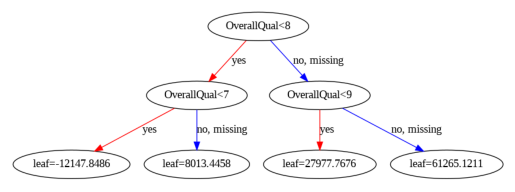

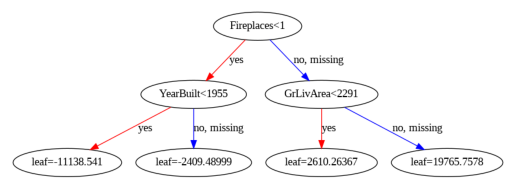

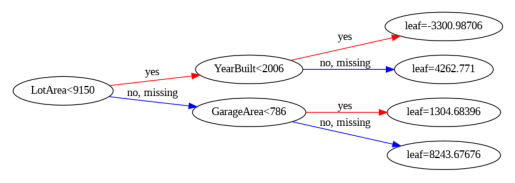

In [38]:

# Create the DMatrix: housing_dmatrix
housing_dmatrix = xgb.DMatrix(data=X, label=y)

# Create the parameter dictionary: params
params = {"objective":"reg:squarederror", "max_depth":2}

# Train the model: xg_reg
xg_reg = xgb.train(params=params, dtrain=housing_dmatrix, num_boost_round=10)

# Plot the first tree
xgb.plot_tree(xg_reg, num_trees=0)
plt.show()

# Plot the fifth tree
xgb.plot_tree(xg_reg, num_trees=4)
plt.show()

# Plot the last tree sideways
xgb.plot_tree(xg_reg, num_trees=9, rankdir="LR")
plt.show()

# They provide insight into how the model arrived at its final decisions and what splits it made to arrive at those decisions.
# This allows us to identify which features are the most important in determining house price.

**Visualizing feature importances:**      
What features are most important in my dataset
Another way to visualize your XGBoost models is to examine the importance of each feature column in the original dataset within the model.

One simple way of doing this involves counting the number of times each feature is split on across all boosting rounds (trees) in the model, and then visualizing the result as a bar graph, with the features ordered according to how many times they appear. XGBoost has a plot_importance() function that allows you to do exactly this,

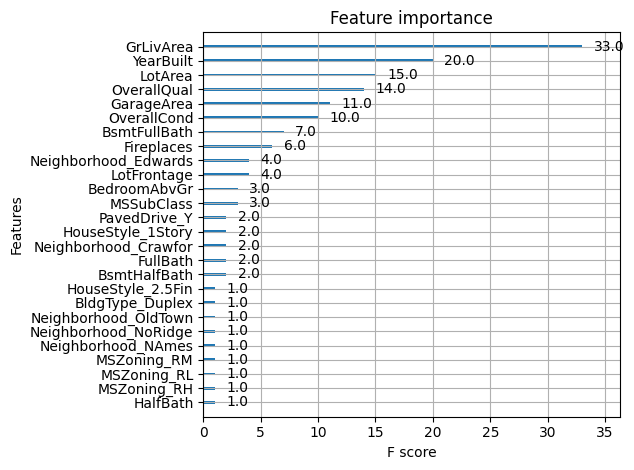

In [41]:


# Create the DMatrix: housing_dmatrix
housing_dmatrix = xgb.DMatrix(data=X, label=y)

# Create the parameter dictionary: params
params = {"objective":"reg:squarederror", "max_depth":4}

# Train the model: xg_reg
xg_reg = xgb.train(dtrain=housing_dmatrix, params=params, num_boost_round=10)

# Plot the feature importances
xgb.plot_importance(xg_reg)
plt.tight_layout()
plt.show()